In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
#import torch.autograd.variable as Variable
from torchvision import transforms

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform=transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.1307,), (0.3081,))]) #converts images to pytorch tensors, normalizes pixel values of images
train_set=torchvision.datasets.MNIST(root='./MNIST_data/train',train=True,transform=transform,download=True) #creates training dataset object
train_loader=torch.utils.data.DataLoader(train_set,batch_size=64,shuffle=True,num_workers=4) #creates training data loader to load data in batches

test_set=torchvision.datasets.MNIST(root='./MNIST_data/test',train=False,transform=transform,download=True) #creates test dataset object
test_loader=torch.utils.data.DataLoader(test_set,batch_size=64,shuffle=True,num_workers=4) #data loader for testing dataset

In [3]:
device

device(type='cpu')

In [4]:
images,label=next(iter(test_loader))
images.size()

torch.Size([64, 1, 28, 28])

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1=nn.Conv2d(1,10,kernel_size=5)
        self.conv2=nn.Conv2d(10,20,kernel_size=5)
        self.conv2_drop=nn.Dropout() #dropout layer
        self.fc1=nn.Linear(320,50)
        self.fc2=nn.Linear(50,10)
         
        self.localization=nn.Sequential(nn.Conv2d(1,8,kernel_size=7),
                                        nn.MaxPool2d(2,stride=2),
                                        nn.ReLU(True),
                                        nn.Conv2d(8,10,kernel_size=5),
                                        nn.MaxPool2d(2,stride=2),
                                        nn.ReLU(True)) #convolutional followed by max pooling and activation function 2x
        self.fc_loc=nn.Sequential(nn.Linear(10*3*3,32),
                                  nn.ReLU(True),
                                  nn.Linear(32,3*2)) #takes output of convolutional layers, reshapes it, passes it through 2 fully connected layers 
                                                     #to output parameters for the spatial transformation
        self.fc_loc[2].weight.data.zero_() #initializes weights of last fully connected layer
        self.fc_loc[2].bias.data.copy_(torch.tensor([1,0,0,0,1,0])) #initalizes bias of last fully connected layer
        
    def stn(self,x): #spatial transformer
        xs=self.localization(x) #localization network extracts relevant features for the spatial transformation
        xs=xs.view(-1,10*3*3) #reshapes
        theta=self.fc_loc(xs) #applies fully connected layer to predict parameters for the spatial transformation
        theta=theta.view(-1,2,3) #reshapes
        grid=F.affine_grid(theta,x.size()) #sampling grid to match coordinates from input image to construct output
        x=F.grid_sample(x,grid)
        return x
    def forward(self,x):
        x=self.stn(x)
        x=F.relu(F.max_pool2d(self.conv1(x),2))
        x=F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)),2))
        x=x.view(-1,320) #flattened to 1-dimensional tensor
        x=self.fc1(x)
        x=F.relu(x)
        x=F.dropout(x,training=self.training)
        x=self.fc2(x)
        return F.log_softmax(x,dim=1) #output tensor containing probabilities for each class
    
net=Net().to(device)
        

In [6]:
images,target=next(iter(train_loader))

In [52]:
optimizer=optim.SGD(net.parameters(),lr=0.01)
t_loss = []
acc = []
def train(epoch):
    net.train()
    for batch_idx,(data,target) in enumerate(train_loader):
        data,target=data.to(device),target.to(device)
        optimizer.zero_grad()
        output=net(data)
        loss=F.nll_loss(output,target)
        loss.backward() #computes gradients of loss
        optimizer.step() #updates model parameters
        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test():
    with torch.no_grad():
        net.eval()
        test_loss=0
        correct=0
        for data,target in test_loader:
            data,target=data.to(device),target.to(device)
            output=net(data)
            test_loss+=F.nll_loss(output,target,size_average=False).item()
            pred=output.max(1,keepdim=True)[1] #obtain predicted class label
            correct+=pred.eq(target.view_as(pred)).sum().item()
        test_loss/=len(test_loader.dataset)
        t_loss.append(test_loss)
        acc.append(correct/len(test_loader.dataset))
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
              .format(test_loss, correct, len(test_loader.dataset),
                      100. * correct / len(test_loader.dataset)))    

/Users/ryanliu/Library/Python/3.9/lib/python/site-packages/torch/nn/functional.py:4404: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/Users/ryanliu/Library/Python/3.9/lib/python/site-packages/torch/nn/functional.py:4343: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


Train Epoch: 1 [0/60000 (0%)]	Loss: 0.038639
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.024104


/Users/ryanliu/Library/Python/3.9/lib/python/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.0255, Accuracy: 9906/10000 (99%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.001986
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.041928

Test set: Average loss: 0.0282, Accuracy: 9917/10000 (99%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.036253
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.001807

Test set: Average loss: 0.0253, Accuracy: 9915/10000 (99%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.011368
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.026115

Test set: Average loss: 0.0258, Accuracy: 9920/10000 (99%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.020379
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.014213

Test set: Average loss: 0.0324, Accuracy: 9892/10000 (99%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.012682
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.024857

Test set: Average loss: 0.0301, Accuracy: 9903/10000 (99%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.005161
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.012549

Test set: Average loss: 0.0264, Accuracy: 9914/10000 (99%)

Tra

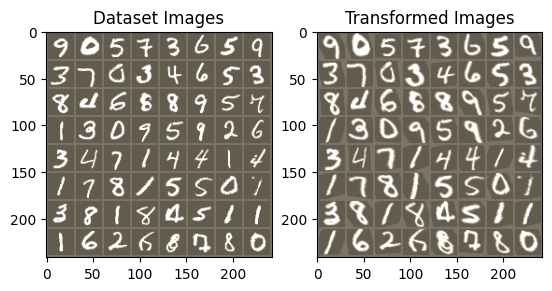

In [53]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

def convert_image_np(image):
    img=image.numpy().transpose((1,2,0))
    mean=np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img=img*std+mean
    img=np.clip(img,0,1)
    return img

def visualize():
    with torch.no_grad():
        data=next(iter(test_loader))[0].to(device)
        input=data
        transformed_input=net.stn(input)
        in_grid=convert_image_np(torchvision.utils.make_grid(input.cpu()))
        out_grid=convert_image_np(torchvision.utils.make_grid(transformed_input.cpu()))
        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')

for epoch in range(1,20):
    train(epoch)
    test()

visualize()    
plt.ioff()
plt.show()


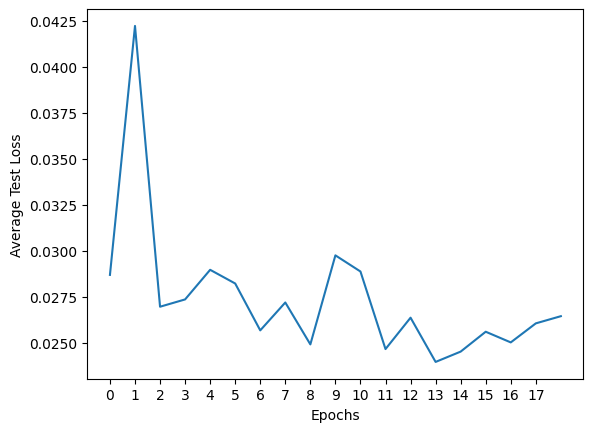

In [45]:
import matplotlib.pyplot as plt
plt.plot(np.arange(19), t_loss)
plt.xticks(np.arange(0, 18, 1))
plt.xlabel('Epochs')
plt.ylabel('Average Test Loss')
plt.show()

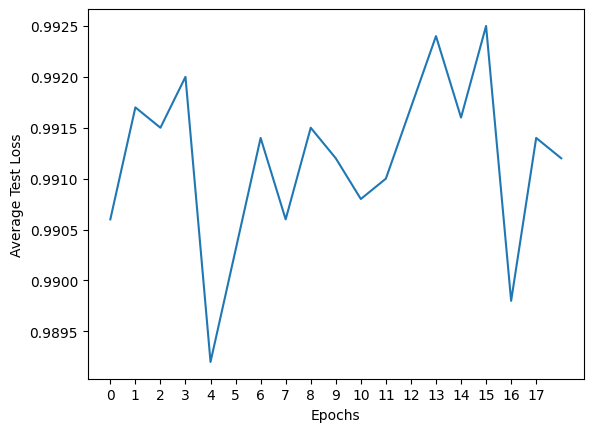

In [56]:
plt.plot(np.arange(19), acc)
plt.xticks(np.arange(0, 18, 1))
plt.xlabel('Epochs')
plt.ylabel('Average Test Accuracy')
plt.show()